# import libraries

In [1]:
%matplotlib inline
# python wrapper for cpp code
from qihmc import Ising

import numpy as np
import matplotlib.pyplot as plt

# MDS problem to qubo map (install the other repo)
from qlp.mds.qubo import get_mds_qubo, QUBO_to_Ising
from qlp.mds.graph_tools import get_plot_mpl
import qlp.mds.graph_tools as gt

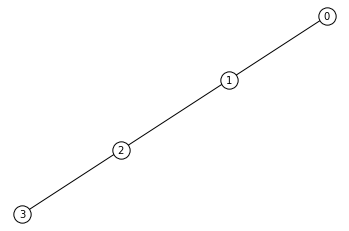

In [2]:
#graph = {(0,1), (1,2),(1,3),(2,4),(3,4),(3,5),(4,6),(5,6)}
graph,_ = gt.generate_nn_graph(4)
get_plot_mpl(graph)
plt.show()

In [3]:
penalty = 2
nodes = set([i for i, _ in graph] + [j for _, j in graph])
n_nodes = len(nodes)

qubo = get_mds_qubo(graph, penalty=penalty, triangularize=True)
J, h, c = QUBO_to_Ising(qubo.todense())

offset = c + penalty * n_nodes

print(J)
print(h)
print(offset)
#print()
#Jsym = J + np.transpose(J)
#print(Jsym)
#print(np.linalg.eigvals(Jsym))

[[ 0.  2.  1.  0. -1. -1. -2.  0.  0.  0.]
 [ 0.  0.  2.  1. -1. -1. -2. -1. -2.  0.]
 [ 0.  0.  0.  2.  0. -1. -2. -1. -2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1. -2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[-2.5 -4.5 -4.5 -2.5  1.   2.   4.   2.   4.   1. ]
18.0


Add parameters used for ising model

In [8]:
beta = 2.
md_steps = 10
ergodicity_jumps = -100
save_frequency = 10

In [5]:
print(Ising.__doc__)

Class wraps HMC solver for spin-glass Hamiltonian such that

    H[psi] = psi@J@psi + h@psi + offset

    and the partition function corresponds to

    Z = sum(exp(- beta H[psi]), psi)


    Attributes:
        J: Spin coupling matrix
        h: External magentic field
        offset: Offset of Hamiltonian
        beta: Inverse termperature
        md_steps: Number of molecular dynamics steps
        ergodicity_jumps: Parameter which helps with erogdicity. Defaults to -100

    Note:
        Multiplies with minus one before inserting in CPP class.

    Todo:
        * Test
        * Think about matrix symmetry
    


In [6]:
ising = Ising(J, h, offset, beta, md_steps, ergodicity_jumps)

('J =', array([[-0., -2., -1., -0.,  1.,  1.,  2., -0., -0., -0.],
       [-2., -0., -2., -1.,  1.,  1.,  2.,  1.,  2., -0.],
       [-1., -2., -0., -2., -0.,  1.,  2.,  1.,  2.,  1.],
       [-0., -1., -2., -0., -0., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0., -2., -0., -0., -0.],
       [ 2.,  2.,  2., -0., -0., -2., -0., -0., -0., -0.],
       [-0.,  1.,  1.,  1., -0., -0., -0., -0., -2., -0.],
       [-0.,  2.,  2.,  2., -0., -0., -0., -2., -0., -0.],
       [-0., -0.,  1.,  1., -0., -0., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  4.5,  4.5,  2.5, -1. , -2. , -4. , -2. , -4. , -1. ]))
('offset =', 18.0)
('C_in =', 8.30413917824215)
('beta =', 2.0)


In [9]:
energies=[]
contEnergies=[]
spins=[]
contSpins=[]
n_therm = 4000
numOfMeasurements = 1000
n_trajectories = 1000
currentMeasurement = 0
while currentMeasurement < numOfMeasurements:
    ising.anneal(.2,beta, n_therm, md_steps)
    save_frequency = 10
    #ising.run_hmc(n_trajectories, save_frequency)
    ising.run_hmc(beta,n_trajectories,md_steps,ergodicity_jumps,save_frequency)
    psi = np.mean(ising.configs, axis=0) / np.sqrt(ising.beta) - ising.k
    pgs = np.floor(psi+.5)  # this takes the spins to their nearest integer
    norm = pgs @ pgs
    # here I check for valid lattice solutions
    if np.floor(norm+.5) == len(pgs):  # if valid, I store solution
        energies.append(pgs @ J @ pgs + h @ pgs + offset)
        spins.append(pgs)
        contEnergies.append(np.mean(ising.energy))
        contSpins.append(psi)
        currentMeasurement += 1

In [11]:
egs = min(energies)
numOfEgs=0
for i in range(len(energies)):
    if energies[i]==egs: numOfEgs += 1
print("# Egs = ",egs, " happened ", numOfEgs, " times")
print("# Prob. of Success = ", numOfEgs*1.0/len(energies))

# Egs =  2.0  happened  564  times
# Prob. of Success =  0.564


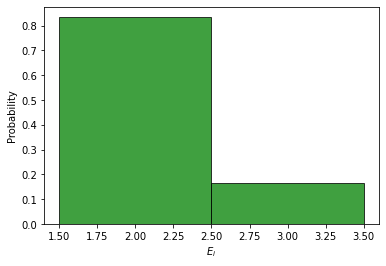

In [10]:
# the histogram of the data
#n, bins, patches = plt.hist(contEnergies, 50, density=1, facecolor='red', alpha=0.75)
n, bins, patches = plt.hist(energies, [-.5 + i for i in range(int(min(energies)),int(max(energies))+1)], edgecolor='Black', density=1, facecolor='green', alpha=0.75)

plt.xlabel(r'$E_i$')
plt.ylabel('Probability')
plt.grid(False)

plt.show()

In [671]:
egs = min(energies)
numOfEgs=0
for i in range(len(energies)):
    if energies[i]==egs:
        print(i," ",egs," ",contEnergies[i])
        print(spins[i])
        print(contSpins[i])

0   2.0   1.9983777017390818
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.02478689 -0.96608862  1.03325831 -0.96659297 -1.01643625  0.97871402
 -1.02375269 -1.0017775  -0.98706857 -1.00618764]
1   2.0   3.0169719296540407
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.00447176 -0.97461217  0.97420978 -0.93590277 -1.00911923  0.95761726
 -0.97862802 -0.96005728 -1.0217575  -0.98596668]
2   2.0   2.5292003441254294
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 0.95735359 -1.06761328 -1.04629442  0.98182461 -0.99009188 -0.95277585
 -0.97033754 -0.96390537 -0.95834172 -0.99336421]
3   2.0   2.758678522681579
[-1.  1. -1.  1. -1. -1. -1.  1. -1. -1.]
[-1.02054578  0.98110253 -1.00935281  0.93746322 -0.97549653 -0.97377978
 -0.96526413  1.0116389  -0.97662136 -1.00497104]
4   2.0   1.5504143704437945
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.04205486 -0.9533223  -0.94833624  1.05247324 -0.98708832 -1.03668784
 -1.03205076 -0.92121713 -1.04312675 -1.00373627]
5   2.0   0.7501397400252884
[ 

207   2.0   2.0021362596458743
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.04348591 -0.97274998  1.03447991 -0.95242    -0.9977742   0.98612499
 -1.03224323 -0.51733545 -1.03514907 -1.00852605]
208   2.0   1.2354541847291391
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.95214651  1.0530885   1.07281023 -0.98774546 -1.00062806  0.96121786
 -1.07383266  0.94092122 -1.05725167 -1.01183105]
209   2.0   1.9329568795167131
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0.96643003 -1.03309787  1.04988058 -1.01632759 -0.98822731  0.98981176
 -0.98149836 -0.9827752  -1.0012184  -0.97835722]
210   2.0   2.7994616468789952
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0.99153728 -1.01774     1.01638456 -1.00476392 -0.97851491  1.01042681
 -1.00164536 -0.7376648  -0.97898191 -0.94760686]
211   2.0   1.5408835958838414
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.05180104 -0.9453662   1.06859009 -0.95791841 -1.0212496   0.91809125
 -1.02533934 -1.00092667 -1.04030029 -1.01104264]
212   2.0   1.659410

379   2.0   0.8055009350454148
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.04159413 -0.93581372 -0.9406787   1.03989309 -1.0348181  -1.06130379
 -1.05317463 -1.04257904 -1.07748718 -1.00900435]
380   2.0   2.9588983618562734
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-1.0208941   0.95922135  0.96453896 -0.99428842 -0.90113257  1.0171746
 -0.96902101  0.98016693 -0.96343904 -0.97606897]
381   2.0   2.153731846852193
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.9990087   0.99404306  1.02204699 -0.94026585 -0.97981445  1.00901548
 -0.99191876  1.02394367 -0.99154198 -0.83129467]
382   2.0   2.12945722683315
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.98312306  1.00173657  0.99434098 -0.95687603 -0.97940543  0.83442785
 -1.01974522  1.04519267 -1.00857525 -0.97380066]
383   2.0   2.1608392822689413
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 0.98303703 -0.98584646 -0.765064    0.70783457 -1.00619999 -1.00751633
 -0.99428405 -1.02176093 -0.9958835  -1.01672403]
384   2.0   2.4998478370

[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-1.00866186  0.99625635  0.9587485  -1.00293679 -0.99898154  1.02663349
 -0.97564394  1.02285172 -0.98461363 -0.98287976]
543   2.0   1.5809075921245437
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.96412952  1.06801719  1.03126594 -0.95289953 -0.99485633  0.92610308
 -1.02170357  0.98679241 -1.05301371 -1.03003691]
544   2.0   1.7906736962904857
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0.9904124  -0.99905237  1.01097296 -1.02150587 -1.00783077  1.01566848
 -1.00069043 -0.99087799 -1.01192735 -0.987523  ]
545   2.0   2.3819070768545494
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-1.04058533  0.97705552  0.93878666 -1.03595607 -1.01147337  0.9895082
 -0.97389784  1.0103316  -0.96351094 -0.90912782]
547   2.0   2.5144186389653442
[-1.  1. -1.  1. -1. -1. -1.  1. -1. -1.]
[-1.04520558  0.94174892 -1.02069731  0.97744805 -1.02340713 -0.97248032
 -0.96334316  1.03202178 -0.96353976 -0.97085928]
548   2.0   2.159957199499379
[ 1. -1.  1. -1. -1.  

631   2.0   2.160759248303275
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.96338732  1.000685    1.0379988  -0.9922805  -1.00562032  0.87147916
 -1.01990596  0.96038638 -1.03076613 -0.99247228]
632   2.0   1.8972853564781653
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.00370182 -1.02762799  1.00183269 -1.04527966 -0.95840628  1.02486049
 -0.9832542  -0.9781303  -0.9826464  -1.00317214]
633   2.0   2.1004988133017948
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.92766565  1.05804184  1.05149599 -0.91592242 -1.00798339  0.9815191
 -1.04992529  0.98144992 -1.0015938  -0.99374488]
634   2.0   1.6791119854520296
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.02027471 -1.02446908  1.02988598 -0.98946427 -0.99310793  0.98714473
 -0.99433689 -1.02874345 -0.97480081 -1.02591688]
635   2.0   1.4094914046174059
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.02470669 -0.99512614  1.05272373 -0.96611043 -0.99940284  1.00003334
 -1.03678212 -1.01364725 -1.02949212 -0.98448664]
636   2.0   2.93028498

[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.05129119 -0.93750083 -0.94186103  1.03595792 -1.01849865 -1.02700647
 -1.05408718 -0.81333665 -1.03853852 -1.01591473]
798   2.0   1.4220919316093714
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.02729081 -0.97987887 -0.95492647  1.02711411 -1.01800666 -1.06236966
 -1.02929139 -0.81520637 -1.03738536 -0.81574973]
799   2.0   1.3475204222782904
[-1.  1. -1.  1. -1. -1. -1.  1. -1. -1.]
[-0.96332743  1.02411016 -0.9658445   1.03767445 -0.87764245 -1.02964343
 -1.04340533  0.96119311 -1.06648656 -1.02991282]
800   2.0   1.7561356461495738
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.99969681  1.00836526  1.04391049 -0.97318299 -1.00833117  0.96948185
 -1.04161933  0.97998049 -1.00652573 -1.00174724]
801   2.0   2.2190507991069706
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0.98320979 -1.00042905  0.98947602 -0.99816609 -1.00149644  1.01448503
 -0.99475968 -0.99827177 -0.98432257 -0.97877905]
802   2.0   1.9994238731849414
[ 1. -1. -1.  1. -1.

894   2.0   1.5402338808879779
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 0.97020278 -0.95293721 -0.96158255  1.00223018 -1.03121905 -1.04661825
 -1.05086481 -1.03282292 -1.02195415 -0.97866273]
895   2.0   2.6294268575637725
[-1.  1. -1.  1. -1. -1. -1.  1. -1. -1.]
[-1.0373745   0.96251161 -1.00667665  0.97627343 -1.01114421 -0.98009548
 -0.98162244  1.0200493  -0.97866981 -0.5955116 ]
896   2.0   2.3967590231570366
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 0.98109298 -1.04876478  0.93100637 -1.04674142 -0.98996338  1.03404031
 -0.97415925 -0.97457923 -0.95705104 -0.99099559]
897   2.0   2.5852826687596617
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-1.0356463   0.95424628  0.99600885 -1.01587249 -0.73758101  1.0309606
 -1.0024003   0.9881434  -0.95091466 -0.97229511]
898   2.0   0.9538193252171466
[ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.08694325 -0.8852537   1.1176203  -0.92560187 -0.99768339  0.98829774
 -1.11133085 -0.54978236 -1.08583217 -1.01627189]
900   2.0   2.5264976

984   2.0   1.7692033915479113
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.01135086 -0.95115392 -0.96374799  1.05401728 -1.0043892  -1.04218714
 -1.01034947 -0.99887985 -1.02147694 -1.00114975]
985   2.0   2.2126273646853334
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 0.95826459 -1.0105026  -1.05460143  0.97845772 -0.97607888 -1.00833617
 -0.9594482  -0.98019509 -1.00020822 -1.02711666]
986   2.0   1.411228101634618
[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[-0.98706425  1.06669649  1.06287807 -0.95024538 -0.88271696  0.92662113
 -1.05901572  0.96208045 -1.06054731 -1.00680437]
987   2.0   1.5664693298411414
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 1.00746181 -1.04074587 -0.99884784  0.9935869  -0.99534238 -1.00840151
 -1.00557579 -1.0232243  -1.00545372 -1.00029941]
988   2.0   3.5991331742873047
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
[ 0.91937043 -1.16395347 -1.13374417  0.90413828 -0.97124223 -0.52895129
 -0.89877576 -0.94685997 -0.89326877 -0.97693937]
990   2.0   3.1487246

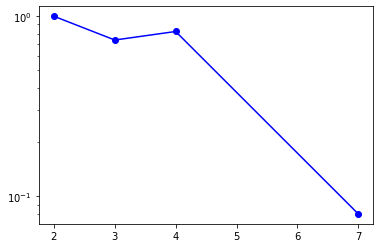

In [2]:
probs = np.array([1,.738,.823,.08])
nodes = np.array([2,3,4,7])
plt.plot(nodes,probs,'bo-')
plt.yscale("log")
plt.show()

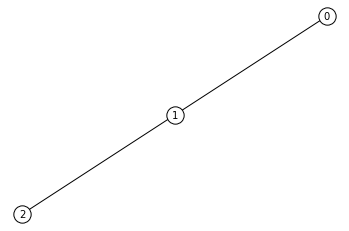

('J =', array([[-0., -2., -1.,  1.,  1.,  2., -0.],
       [-2., -0., -2.,  1.,  1.,  2.,  1.],
       [-1., -2., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -2., -0.],
       [ 2.,  2.,  2., -0., -2., -0., -0.],
       [-0.,  1.,  1., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  3.5,  2.5, -1. , -2. , -4. , -1. ]))
('offset =', 11.5)
('C_in =', 6.869786498565076)
('beta =', 3.0)
# Number of nodes =  3
# Egs =  1.0  happened  671  times
# Prob. of Success =  0.671



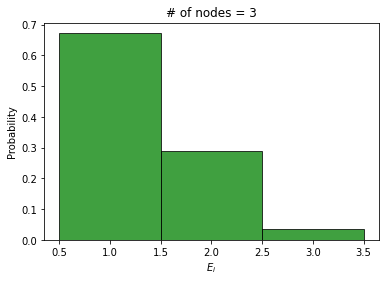

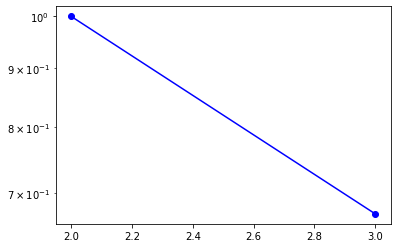

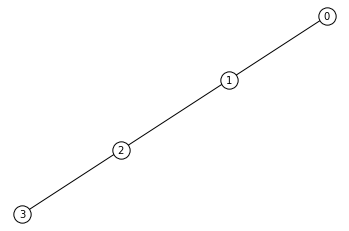

('J =', array([[-0., -2., -1., -0.,  1.,  1.,  2., -0., -0., -0.],
       [-2., -0., -2., -1.,  1.,  1.,  2.,  1.,  2., -0.],
       [-1., -2., -0., -2., -0.,  1.,  2.,  1.,  2.,  1.],
       [-0., -1., -2., -0., -0., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0., -2., -0., -0., -0.],
       [ 2.,  2.,  2., -0., -0., -2., -0., -0., -0., -0.],
       [-0.,  1.,  1.,  1., -0., -0., -0., -0., -2., -0.],
       [-0.,  2.,  2.,  2., -0., -0., -0., -2., -0., -0.],
       [-0., -0.,  1.,  1., -0., -0., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  4.5,  4.5,  2.5, -1. , -2. , -4. , -2. , -4. , -1. ]))
('offset =', 18.0)
('C_in =', 8.304139178242155)
('beta =', 3.0)
# Number of nodes =  4
# Egs =  2.0  happened  637  times
# Prob. of Success =  0.637



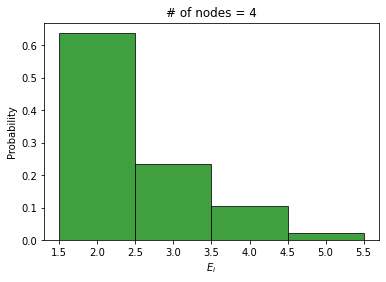

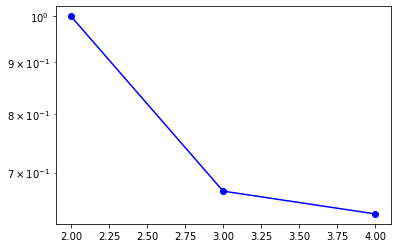

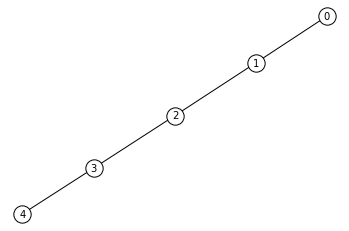

('J =', array([[-0., -2., -1., -0., -0.,  1.,  1.,  2., -0., -0., -0., -0., -0.],
       [-2., -0., -2., -1., -0.,  1.,  1.,  2.,  1.,  2., -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0.],
       [-0., -1., -2., -0., -2., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.],
       [-0., -0., -1., -2., -0., -0., -0., -0., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0., -0., -2., -0., -0., -0., -0., -0.],
       [ 2.,  2.,  2., -0., -0., -0., -2., -0., -0., -0., -0., -0., -0.],
       [-0.,  1.,  1.,  1., -0., -0., -0., -0., -0., -2., -0., -0., -0.],
       [-0.,  2.,  2.,  2., -0., -0., -0., -0., -2., -0., -0., -0., -0.],
       [-0., -0.,  1.,  1.,  1., -0., -0., -0., -0., -0., -0., -2., -0.],
       [-0., -0.,  2.,  2.,  2., -0., -0., -0., -0., -0., -2., -0., -0.],
       [-0., -0., -0.,  1.,  1., -0., -0., -0., -0., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  4.

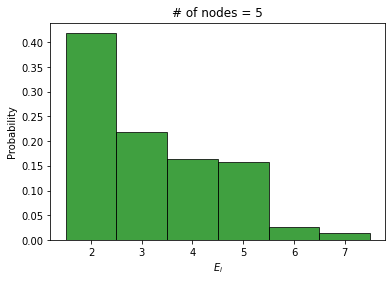

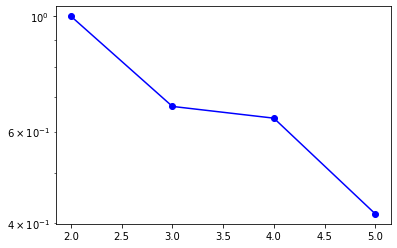

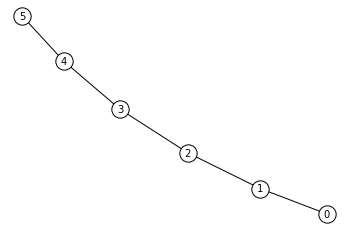

('J =', array([[-0., -2., -1., -0., -0., -0.,  1.,  1.,  2., -0., -0., -0., -0.,
        -0., -0., -0.],
       [-2., -0., -2., -1., -0., -0.,  1.,  1.,  2.,  1.,  2., -0., -0.,
        -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2.,
        -0., -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0.,  1.,  2.,  1.,  2.,
         1.,  2., -0.],
       [-0., -0., -1., -2., -0., -2., -0., -0., -0., -0., -0.,  1.,  2.,
         1.,  2.,  1.],
       [-0., -0., -0., -1., -2., -0., -0., -0., -0., -0., -0., -0., -0.,
         1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0., -0., -0., -2., -0., -0., -0., -0.,
        -0., -0., -0.],
       [ 2.,  2.,  2., -0., -0., -0., -0., -2., -0., -0., -0., -0., -0.,
        -0., -0., -0.],
       [-0.,  1.,  1.,  1., -0., -0., -0., -0., -0., -0., -2., -0., -0.,
        -0., -0., -0.],
       [-0.,  2.,  2.,

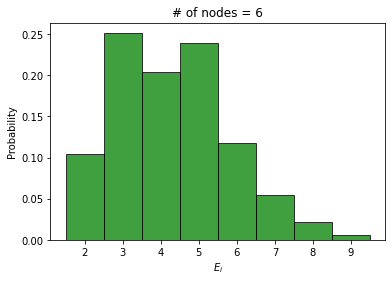

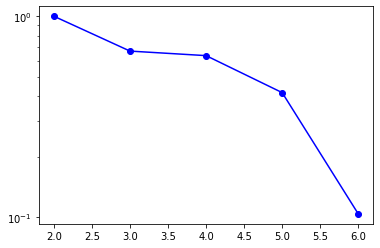

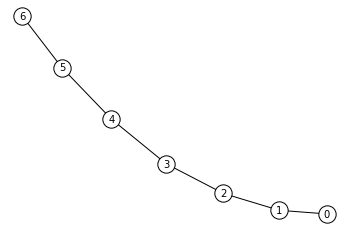

('J =', array([[-0., -2., -1., -0., -0., -0., -0.,  1.,  1.,  2., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0.],
       [-2., -0., -2., -1., -0., -0., -0.,  1.,  1.,  2.,  1.,  2., -0.,
        -0., -0., -0., -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,
         2., -0., -0., -0., -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0., -0.,  1.,  2.,  1.,
         2.,  1.,  2., -0., -0., -0.],
       [-0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,  1.,
         2.,  1.,  2.,  1.,  2., -0.],
       [-0., -0., -0., -1., -2., -0., -2., -0., -0., -0., -0., -0., -0.,
        -0.,  1.,  2.,  1.,  2.,  1.],
       [-0., -0., -0., -0., -1., -2., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0., -0., -0., -0., -2., -0., -0., -0.,
        -0., -0., -0., 

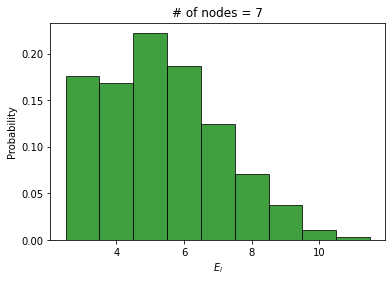

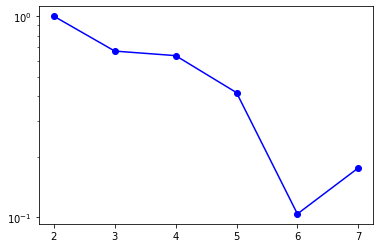

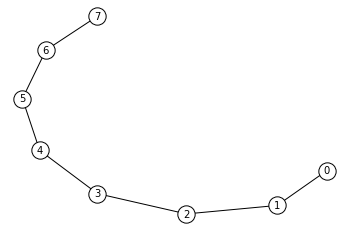

('J =', array([[-0., -2., -1., -0., -0., -0., -0., -0.,  1.,  1.,  2., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-2., -0., -2., -1., -0., -0., -0., -0.,  1.,  1.,  2.,  1.,  2.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0., -0., -0.,  1.,  2.,  1.,  2.,
         1.,  2., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,  1.,  2.,
         1.,  2.,  1.,  2., -0., -0., -0., -0., -0.],
       [-0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,
         1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0.],
       [-0., -0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,
        -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0.],
       [-0., -0., -0., -0., -1., -2., -0., -2., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.],
       [-0., -0., -0., -0., -0., -1., -2., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0

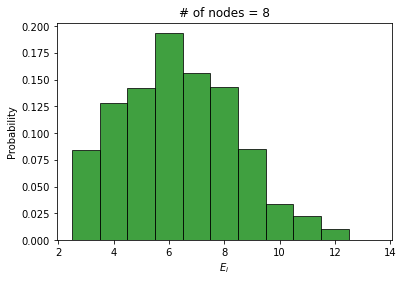

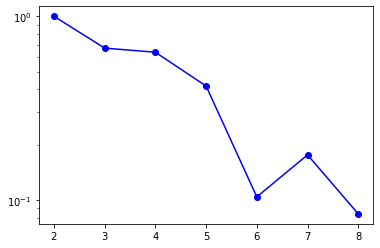

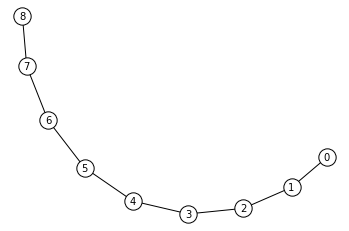

('J =', array([[-0., -2., -1., -0., -0., -0., -0., -0., -0.,  1.,  1.,  2., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-2., -0., -2., -1., -0., -0., -0., -0., -0.,  1.,  1.,  2.,  1.,
         2., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,  1.,  2.,  1.,
         2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,  1.,
         2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,
        -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,
        -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0.],
       [-0., -0., -0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0.]

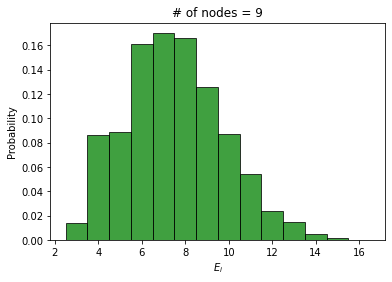

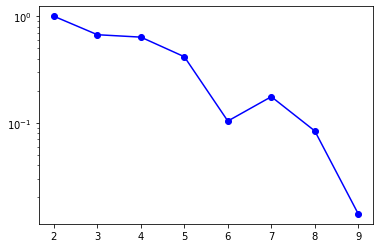

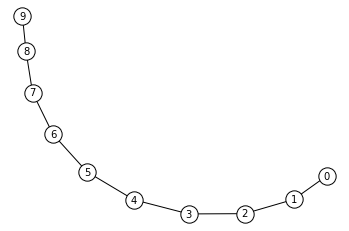

('J =', array([[-0., -2., -1., -0., -0., -0., -0., -0., -0., -0.,  1.,  1.,  2.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,  1.,  1.,  2.,
         1.,  2., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,  1.,  2.,
         1.,  2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0., -0.,
         1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,
        -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-0., -0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0.,
        -0., -0.],
  

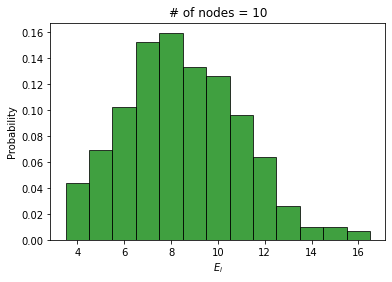

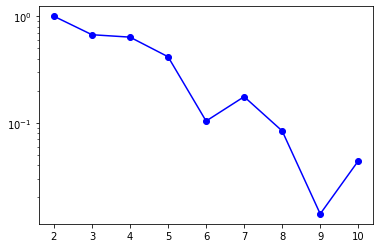

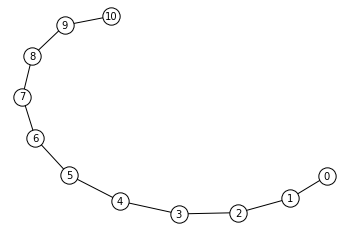

('J =', array([[-0., -2., -1., -0., -0., -0., -0., -0., -0., -0., -0.,  1.,  1.,
         2., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.],
       [-2., -0., -2., -1., -0., -0., -0., -0., -0., -0., -0.,  1.,  1.,
         2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.],
       [-1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0., -0.,  1.,
         2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.],
       [-0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0., -0.,
        -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.],
       [-0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -2., -0., -2., -1., -0., -0., -0., -0., -0.,
        -0., -0., -

KeyboardInterrupt: 

In [14]:
beta = 3.
init_beta = .2
md_steps_therm = 10
md_steps = 5
ergodicity_jumps = 100
numOfMeasurements = 1000
n_therm = 1000000
n_trajectories = 10000
save_frequency = 10
#probs = [1, 0.738, 0.823, 0.657, 0.271, 0.568, 0.336, 0.1, 0.318, 0.158, 0.029, 0.169, 0.055]
#nds = [2,3,4,5,6,7,8,9,10,11,12,13,14]
probs=[1]
nds=[2]

for nn in range(3,15):
    graph,_ = gt.generate_nn_graph(nn)
    get_plot_mpl(graph)
    plt.show()
    
    penalty = 2
    nodes = set([i for i, _ in graph] + [j for _, j in graph])
    n_nodes = len(nodes)
    qubo = get_mds_qubo(graph, penalty=penalty, triangularize=True)
    J, h, c = QUBO_to_Ising(qubo.todense())
    offset = c + penalty * n_nodes
    
    ising = Ising(J, h, offset, beta, md_steps, ergodicity_jumps)
    
    energies=[]
    contEnergies=[]
    spins=[]
    contSpins=[]
    currentMeasurement = 0
    while currentMeasurement < numOfMeasurements:
        ising.annealAndTurnOnH(init_beta,beta,n_therm, md_steps_therm,ergodicity_jumps)
        ising.run_hmc(beta,n_trajectories,md_steps,-1,save_frequency)
        psi = np.mean(ising.configs, axis=0) / np.sqrt(ising.beta) - ising.k
        pgs = np.floor(psi+.5)  # this takes the spins to their nearest integer
        norm = pgs @ pgs
        # here I check for valid lattice solutions
        if np.floor(norm+.5) == len(pgs):  # if valid, I store solution
            energies.append(pgs @ J @ pgs + h @ pgs + offset)
            spins.append(pgs)
            contEnergies.append(np.mean(ising.energy))
            contSpins.append(psi)
            currentMeasurement += 1
            
    egs = min(energies)
    numOfEgs=0
    for i in range(len(energies)):
        if energies[i]==egs: numOfEgs += 1
    print("# Number of nodes = ",nn)
    print("# Egs = ",egs, " happened ", numOfEgs, " times")
    print("# Prob. of Success = ", numOfEgs*1.0/len(energies))
    probs.append(numOfEgs*1.0/len(energies))
    nds.append(nn)
    print("")
    
    n, bins, patches = plt.hist(energies, [-.5 + i for i in range(int(min(energies)),int(max(energies))+1)], edgecolor='Black', density=1, facecolor='green', alpha=0.75)
    plt.xlabel(r'$E_i$')
    plt.ylabel('Probability')
    plt.title("# of nodes = "+str(nn))
    plt.grid(False)
    plt.show()
    
    plt.plot(nds,probs,'bo-')
    plt.yscale("log")
    plt.show()

In [12]:
probs

[1, 0.652, 0.704]

In [3]:
dw=[1,0.5274997063702609,0.6812920690579608,0.3162277660168376,0.1598467106434318,0.3162277660168376,0.12915496650148814 ,0.020644996558525544 ,0.10435626297753914 ,0.057445929282459014 ,0.005994842503189403 ,0.030302710828663964
, 0.008799225435691066]
dwnds=[2,3,4,5,6,7,8,9,10,11,12,13,14]

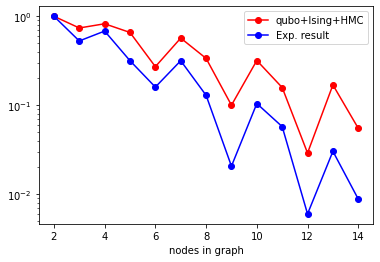

In [4]:
plt.plot(nds,probs,'ro-',label='qubo+Ising+HMC')
plt.plot(dwnds,dw,'bo-',label='Exp. result')
plt.yscale("log")
plt.xlabel("nodes in graph")
plt.legend()
plt.show()

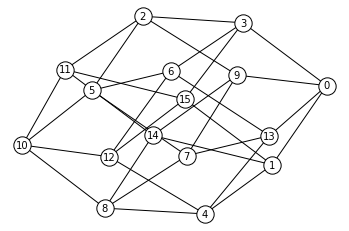

In [86]:
graph,_ = gt.generate_hamming_graph(4,2)
get_plot_mpl(graph)
plt.show()

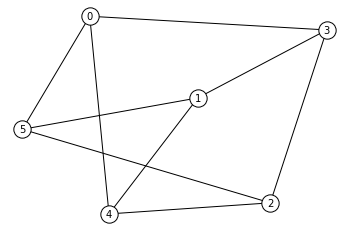

In [33]:
graph,_ = gt.generate_bipartite_graph(3,3)
get_plot_mpl(graph)
plt.show()

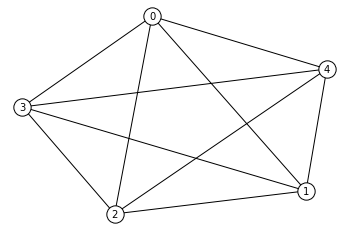

In [89]:
graph,_ = gt.generate_erdos_renyi_graph(5,5)
get_plot_mpl(graph)
plt.show()

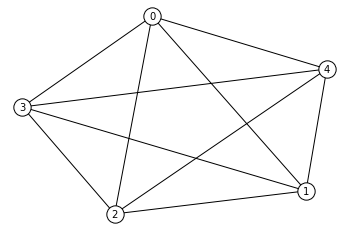

In [50]:
graph,_ = gt.generate_newman_watts_strogatz_graph(5,3,2)
get_plot_mpl(graph)
plt.show()

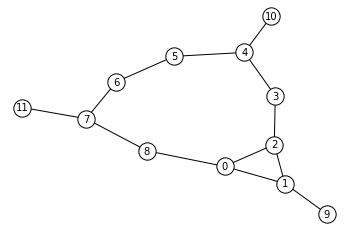

In [78]:
graph,_ = gt.generate_corona_graph(3,1)
get_plot_mpl(graph)
plt.show()

In [90]:
penalty = 2
nodes = set([i for i, _ in graph] + [j for _, j in graph])
n_nodes = len(nodes)

qubo = get_mds_qubo(graph, penalty=penalty, triangularize=True)
J, h, c = QUBO_to_Ising(qubo.todense())

offset = c + penalty * n_nodes
print(J)
print(h)
print(offset)

[[ 0.  5.  5.  5.  5. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1.
  -2. -4.]
 [ 0.  0.  5.  5.  5. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1.
  -2. -4.]
 [ 0.  0.  0.  5.  5. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1.
  -2. -4.]
 [ 0.  0.  0.  0.  5. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1.
  -2. -4.]
 [ 0.  0.  0.  0.  0. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1. -2. -4. -1.
  -2. -4.]
 [ 0.  0.  0.  0.  0.  0.  2.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  4.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  4.  0.  0.

In [8]:
probs

[1, 0.738, 0.823, 0.657, 0.271, 0.568, 0.336, 0.1, 0.318, 0.158, 0.029, 0.169]